In [ ]:
!pip -q install torch_geometric

import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.4 MB/s eta 0:00:00


In [ ]:
from torch_geometric.utils import to_networkx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.loader import DataLoader
from torch.optim import Adam

### **Загружаем датасет и выводим его**

In [ ]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()

In [ ]:
# Print information
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

KarateClub()
------------
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [ ]:
data = dataset[0]

In [ ]:
data

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

In [ ]:
data.x.shape
y = data.y

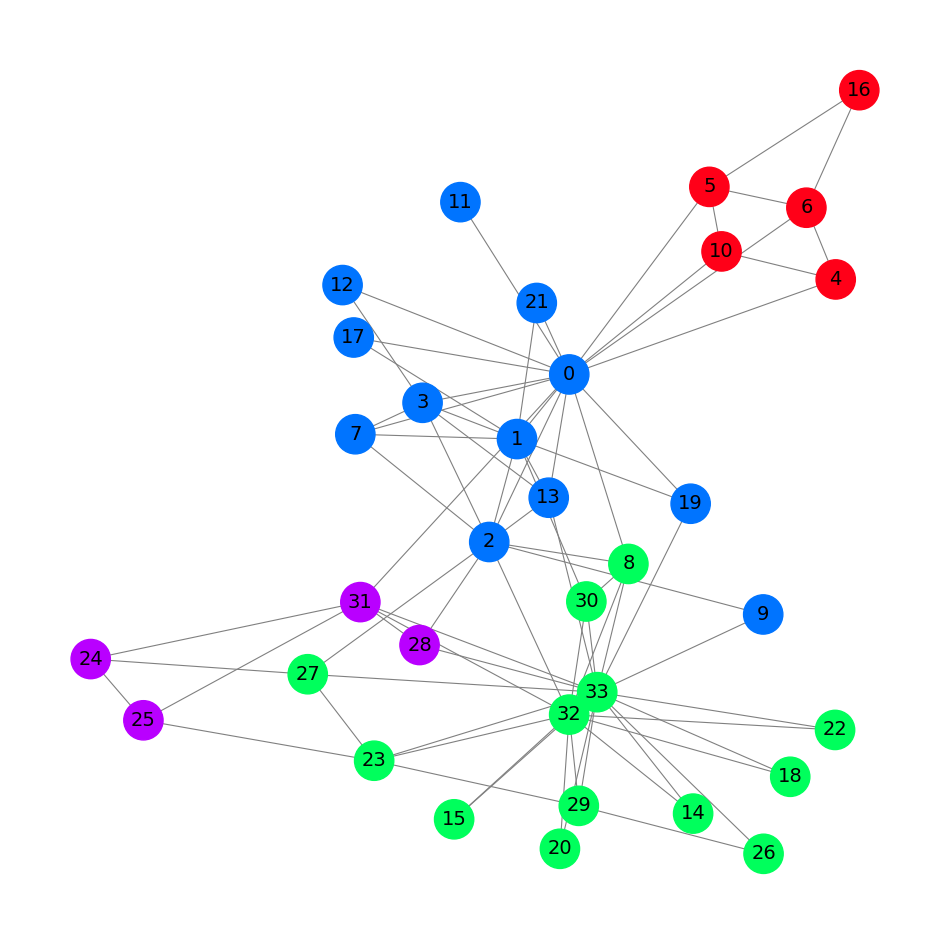

In [ ]:
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=800,
                node_color=data.y,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=14
                )
plt.show()

###**Модель RNN**

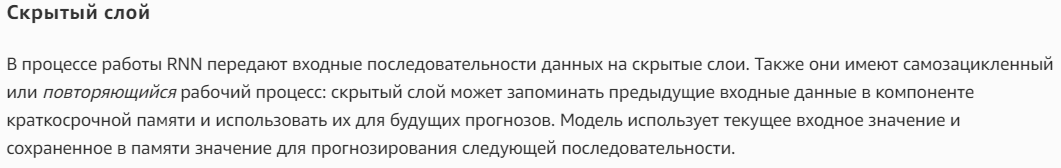

In [ ]:
class GRNN_MP(MessagePassing):
    def __init__(self, input_dim, hidden_dim):
        super().__init__(aggr='add')

        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=False, nonlinearity='tanh')

        self.initial_hidden_state = torch.zeros(1, hidden_dim)  # Начальное скрытое состояние
        self.bias_parameter = nn.Parameter(torch.empty(hidden_dim))  # Параметр смещения
        self.reset_parameters()  # Сброс параметров

    def reset_parameters(self):
        self.rnn.reset_parameters()
        self.bias_parameter.data.zero_()

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        x, hn = self.rnn(x, self.initial_hidden_state)
        assert self.initial_hidden_state.shape == hn.shape
        hn = hn.detach()
        self.initial_hidden_state = hn

        row, col = edge_index
        degrees = degree(col, x.size(0), dtype=x.dtype)
        degrees_inv_sqrt = degrees.pow(-0.5)
        degrees_inv_sqrt[degrees_inv_sqrt == float('inf')] = 0
        norm = degrees_inv_sqrt[row] * degrees_inv_sqrt[col]

        out = self.propagate(edge_index, x=x, norm=norm)
        out = out + self.bias_parameter

        return out, hn

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

In [ ]:
class GRNN(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(GRNN, self).__init__()
    self.rnn = GRNN_MP(input_dim, hidden_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x, edge_index):
    out, hn   = self.rnn(x, edge_index)
    out = self.fc(out)
    return out, hn

In [ ]:
model = GRNN(data.x.shape[1], 32, y.unique().shape[0] )

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

In [ ]:
total = []

In [ ]:
def train_loop(model, criterion, optimizer, num_epochs = 50, print_every = 10):
  global total
  embeddings = []
  losses = []
  accuracies = []
  outputs = []

  for epoch in range(num_epochs+1):

      optimizer.zero_grad()
      z, h = model(data.x, data.edge_index)
      loss = criterion(z, y)
      acc = accuracy(z.argmax(dim=1), data.y)
      loss.backward()


      optimizer.step()

      embeddings.append(h)
      losses.append(loss)
      accuracies.append(acc)
      outputs.append(z.argmax(dim=1))

      if epoch % print_every == 0:
          print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')

  total.append({'model': model, 'accuracy': accuracies[-1].item()})
  return model, embeddings, losses, accuracies, outputs

model, embeddings, losses, accuracies, outputs = train_loop(model, criterion, optimizer)
h = embeddings[-1]

Epoch   0 | Loss: 1.42 | Acc: 14.71%
Epoch  10 | Loss: 0.85 | Acc: 85.29%
Epoch  20 | Loss: 0.29 | Acc: 97.06%
Epoch  30 | Loss: 0.08 | Acc: 100.00%
Epoch  40 | Loss: 0.03 | Acc: 100.00%
Epoch  50 | Loss: 0.02 | Acc: 100.00%


###**Модель GCN (графовая сверточная сеть)**

In [ ]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(dataset.num_features, 3)
        self.out = Linear(3, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z

In [ ]:
model = GCN()
print(model)

GCN(
  (gcn): GCNConv(34, 3)
  (out): Linear(in_features=3, out_features=4, bias=True)
)


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

In [ ]:
def train_loop(model, criterion, optimizer, num_epochs = 301, print_every = 10):
  global total
  embeddings = []
  losses = []
  accuracies = []
  outputs = []

  for epoch in range(num_epochs):

      optimizer.zero_grad()
      h, z = model(data.x, data.edge_index)
      loss = criterion(z, data.y)
      acc = accuracy(z.argmax(dim=1), data.y)
      loss.backward()


      optimizer.step()

      embeddings.append(h)
      losses.append(loss)
      accuracies.append(acc)
      outputs.append(z.argmax(dim=1))

      if epoch % print_every == 0:
          print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')

  total.append({'model': model, 'accuracy': accuracies[-1].item()})
  return model, embeddings, losses, accuracies, outputs

model, embeddings, losses, accuracies, outputs = train_loop(model, criterion, optimizer)
h = embeddings[-1]

Epoch   0 | Loss: 1.33 | Acc: 38.24%
Epoch  10 | Loss: 1.12 | Acc: 67.65%
Epoch  20 | Loss: 0.89 | Acc: 73.53%
Epoch  30 | Loss: 0.65 | Acc: 73.53%
Epoch  40 | Loss: 0.43 | Acc: 88.24%
Epoch  50 | Loss: 0.28 | Acc: 91.18%
Epoch  60 | Loss: 0.19 | Acc: 97.06%
Epoch  70 | Loss: 0.14 | Acc: 100.00%
Epoch  80 | Loss: 0.10 | Acc: 100.00%
Epoch  90 | Loss: 0.08 | Acc: 100.00%
Epoch 100 | Loss: 0.06 | Acc: 100.00%
Epoch 110 | Loss: 0.05 | Acc: 100.00%
Epoch 120 | Loss: 0.04 | Acc: 100.00%
Epoch 130 | Loss: 0.04 | Acc: 100.00%
Epoch 140 | Loss: 0.03 | Acc: 100.00%
Epoch 150 | Loss: 0.03 | Acc: 100.00%
Epoch 160 | Loss: 0.02 | Acc: 100.00%
Epoch 170 | Loss: 0.02 | Acc: 100.00%
Epoch 180 | Loss: 0.02 | Acc: 100.00%
Epoch 190 | Loss: 0.02 | Acc: 100.00%
Epoch 200 | Loss: 0.02 | Acc: 100.00%
Epoch 210 | Loss: 0.01 | Acc: 100.00%
Epoch 220 | Loss: 0.01 | Acc: 100.00%
Epoch 230 | Loss: 0.01 | Acc: 100.00%
Epoch 240 | Loss: 0.01 | Acc: 100.00%
Epoch 250 | Loss: 0.01 | Acc: 100.00%
Epoch 260 | Loss: 0

###**Альтернативные модели**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [ ]:
def train_and_eval(model, x, y):
  global total
  model.fit(x, y)
  pred_y = model.predict(x)
  accuracy = accuracy_score(y, pred_y)
  total.append({'model': model, 'accuracy': accuracy})
  print(f'Model: {type(model).__name__} | Accuracy: {accuracy:.3f}')

In [ ]:
models = [LogisticRegression(max_iter=1000), RandomForestClassifier(), DecisionTreeClassifier(), GaussianNB(), KNeighborsClassifier()]
for model in models:
  train_and_eval(model, data.x, data.y)

Model: LogisticRegression | Accuracy: 0.882
Model: RandomForestClassifier | Accuracy: 1.000
Model: DecisionTreeClassifier | Accuracy: 1.000
Model: GaussianNB | Accuracy: 1.000
Model: KNeighborsClassifier | Accuracy: 0.353


###**Результаты**

In [ ]:
import pandas as pd

In [ ]:
total_df = pd.DataFrame(total)
total_df

,model,accuracy
0,GRNN(\n (rnn): GRNN_MP()\n (fc): Linear(in_f...,1.000000
1,"GCN(\n (gcn): GCNConv(34, 3)\n (out): Linear...",1.000000
2,LogisticRegression(max_iter=1000),0.882353
3,"(DecisionTreeClassifier(max_features='sqrt', r...",1.000000
4,DecisionTreeClassifier(),1.000000
5,GaussianNB(),1.000000
6,KNeighborsClassifier(),0.352941
